In [1]:
import pandas as pd
df = pd.read_csv('Scrapper/final.csv', header=None)
df.rename(columns={0: 'comment', 1: 'category'}, inplace=True)

In [2]:
# df.head()
df.category.unique()

array(['positive', 'suggestion', 'question', 'other', 'correction',
       'negative'], dtype=object)

In [3]:
df['category_id'] = df['category'].factorize()[0]
df.head()

,comment,category,category_id
0,Love you sir!!,positive,0
1,Please make videos on..Midpoint circle drawing...,suggestion,1
2,I bought both of your courses on Udemy. You ar...,question,2
3,"Thank you very much, u really got me in the fi...",positive,0
4,i hope u are ok with everything going on again...,other,3


In [4]:
print(df[df.isna().any(axis=1)])

Empty DataFrame
Columns: [comment, category, category_id]
Index: []


In [5]:
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
df.head()

,comment,category,category_id
0,Love you sir!!,positive,0
1,Please make videos on..Midpoint circle drawing...,suggestion,1
2,I bought both of your courses on Udemy. You ar...,question,2
3,"Thank you very much, u really got me in the fi...",positive,0
4,i hope u are ok with everything going on again...,other,3


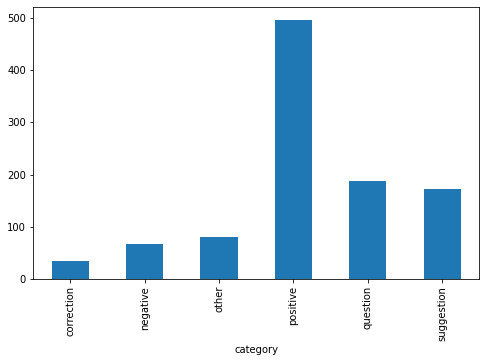

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,5))
df.groupby('category').comment.count().plot.bar(ylim=0)
plt.show()

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.comment).toarray()
labels = df.category_id
features.shape

(1038, 332)

In [8]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2

for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'correction':
  . Most correlated unigrams:
. dx
. wrong
  . Most correlated bigrams:
. 35 56
. 2dy dx
# 'negative':
  . Most correlated unigrams:
. fucking
. fuck
  . Most correlated bigrams:
. want learn
. doesn work
# 'other':
  . Most correlated unigrams:
. https
. com
  . Most correlated bigrams:
. thank sir
. https www
# 'positive':
  . Most correlated unigrams:
. thanks
. thank
  . Most correlated bigrams:
. sir make
. thank sir
# 'question':
  . Most correlated unigrams:
. thank
. using
  . Most correlated bigrams:
. dynamic programming
. thank sir
# 'suggestion':
  . Most correlated unigrams:
. circle
. make
  . Most correlated bigrams:
. make video
. sir make


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['comment'], df['category'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [10]:
print(clf.predict(count_vect.transform(["please"])))

['suggestion']


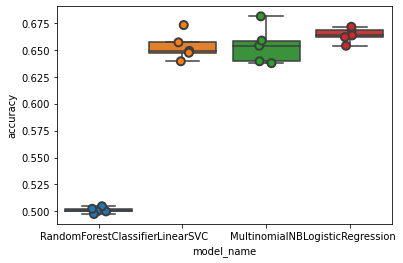

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [12]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.653177
LogisticRegression        0.663782
MultinomialNB             0.654153
RandomForestClassifier    0.500962
Name: accuracy, dtype: float64

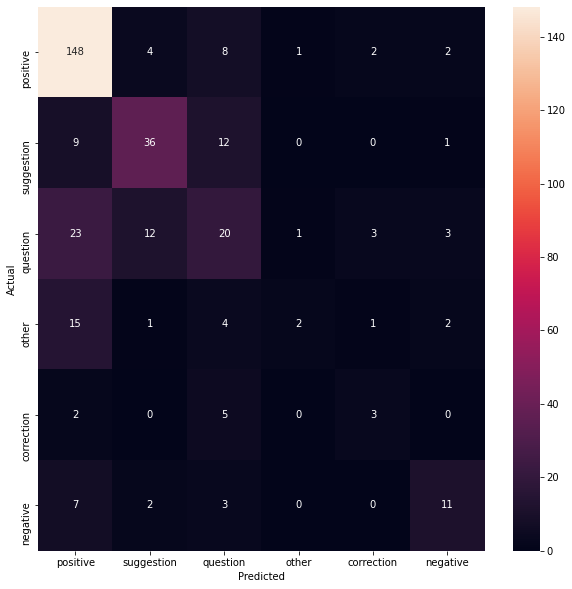

In [13]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [14]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category', 'comment']])
      print('')

'question' predicted as 'positive' : 23 examples.


,category,comment
936,question,Indian accent?
885,question,"Sir, what are subjects , you are teaching? Yo..."
294,question,what is c in d1 formula
403,question,What if (p=0)
783,question,but 2 and 5 are not connected?? how are we vis...
810,question,But sir to find the pattern it will take a lot...
2,question,I bought both of your courses on Udemy. You ar...
811,question,Why T is not being included in this? T is also...
700,question,Casually explained? Is that you?
317,question,What should we do? If slope(m)<0



'other' predicted as 'positive' : 15 examples.


,category,comment
672,other,Bo*** for noobs.
520,other,Allah bhala kry is indian bhai jaan kaa inki w...
440,other,2019 April? Before End Game?
970,other,马马虎虎
650,other,"Sir miru bagha chepparu,enka isam ,hashing kud..."
202,other,absolute madlad
682,other,*Illiteracy rate drops to 0%*
397,other,Example at 38:00
439,other,421 * we were this close to achieving greatness *
603,other,Why is rasgulla in his mouth while teaching.



'question' predicted as 'suggestion' : 12 examples.


,category,comment
822,question,Sir can u upload a video on algorithms of reli...
511,question,Anyone know what order to watch these videos? ...
807,question,Aren't both of the approach dynamic programmin...
787,question,sir bresenhams kab hoga upload???
798,question,When are you going to upload the entire course??
30,question,Sir can u please explain - online algorithms.....
587,question,Excuse me sir. Which is the recurrence relati...
489,question,Sir can you make a video on string matching wi...
799,question,"Sir a/w ager cost 2=28 path (1,2) and cost5=28..."
366,question,sir asalaamualaikum. if pk helps us to decide ...



'suggestion' predicted as 'question' : 12 examples.


,category,comment
175,suggestion,"Sir, could you start teaching python programmi..."
862,suggestion,Please add a video for naive string matching a...
866,suggestion,sir plzz make a video on SHORTEST UNCOMMON SUB...
1016,suggestion,to reduce errors and frustration:1) use Jupyte...
8,suggestion,Just one suggestion: if possible can you provi...
571,suggestion,Sir i dont know who runs your audio but he's r...
465,suggestion,Sir it would be really helpful if u included t...
40,suggestion,sir please delete that first one...it will be ...
181,suggestion,Sir welcome back ... I am expecting your new v...
451,suggestion,"Great explanation sir. Just to add, the worst ..."


In [15]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['category'].unique()))

              precision    recall  f1-score   support

    positive       0.73      0.90      0.80       165
  suggestion       0.65      0.62      0.64        58
    question       0.38      0.32      0.35        62
       other       0.50      0.08      0.14        25
  correction       0.33      0.30      0.32        10
    negative       0.58      0.48      0.52        23

    accuracy                           0.64       343
   macro avg       0.53      0.45      0.46       343
weighted avg       0.61      0.64      0.61       343

